In [1]:
import re
import json
import os
from tqdm import tqdm
import pandas as pd
from glob import glob
from collections import defaultdict
from ner_metrics import classification_report

### Postprocessing LLM output

In [114]:
input_dir = "/home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/"
output_dir = "/home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER_clean/"

os.makedirs(output_dir, exist_ok=True)

In [115]:
csv_path = "/home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/data/processed_test_set.csv"
ground_truth_df = pd.read_csv(csv_path)

In [116]:
# Regex pattern for extracting text (Standard Format)
text_pattern = re.compile(r'text\s*=\s*"(.*?)"', re.DOTALL)

# Regex pattern for extracting standard format annotations
annotation_pattern = re.compile(
    r'Annotation\s*\(\s*start\s*=\s*(\d+),\s*end\s*=\s*(\d+),\s*term\s*=\s*"(.*?)",\s*label\s*=\s*"(.*?)"\s*\)',
    re.DOTALL
)

# Extracts nested annotations **without regex**
def extract_nested_annotations(content):
    """Extracts annotations from the nested format manually, ensuring completeness."""
    annotations = []
    blocks = content.split("Annotation = {")  # Split into blocks

    for block in blocks[1:]:  # Skip first split (garbage before first annotation)
        try:
            start = block.split("AnnotationStart = ")[1].split(",")[0].strip()
            end = block.split("AnnotationEnd = ")[1].split(",")[0].strip()
            term = block.split('Term = "')[1].split('",')[0].strip()
            label = block.split('Label = "')[1].split('",')[0].strip()

            # Convert start & end to int and ensure they are valid
            start, end = int(start), int(end)
            if start == end:
                continue  # Skip invalid annotations

            annotations.append({
                "start": start,
                "end": end,
                "term": term,
                "label": label
            })
        except Exception as e:
            print(f"Failed to parse annotation block: {block[:50]}... Error: {e}")

    return annotations

# Extract text from the processed column of ground truth
def extract_text_from_ground_truth(index):
    """Extracts only the text field from the ground truth CSV."""
    if 0 <= index < len(ground_truth_df):
        match = re.search(r'text\s*=\s*"(.*?)"', ground_truth_df.loc[index, "processed"], re.DOTALL)
        return match.group(1).strip() if match else ""
    return ""

# Processes each JSON file
def process_file(file_path, output_path, record_index):
    """Processes a single JSON file, extracts annotations, and saves the cleaned version."""

    with open(file_path, "r", encoding="utf-8") as file:
        raw_content = file.read()

    raw_content = raw_content.replace('\\"', '"')

    text_match = text_pattern.search(raw_content)
    text = text_match.group(1).strip() if text_match else ""

    # Only add ground truth text if missing
    if not text:
        text = extract_text_from_ground_truth(record_index)

    annotations = []

    for match in annotation_pattern.finditer(raw_content):
        start, end, term, label = match.groups()
        start, end = int(start), int(end)

        if start == end:
            continue

        annotations.append({
            "start": start,
            "end": end,
            "term": term.strip(),
            "label": label.strip()
        })

    if "Annotation =" in raw_content:
        annotations.extend(extract_nested_annotations(raw_content))

    unique_annotations = []
    seen = set()
    for ann in annotations:
        key = (ann["start"], ann["end"], ann["term"], ann["label"])
        if key not in seen:
            seen.add(key)
            unique_annotations.append(ann)

    cleaned_data = {
        "text": text,
        "annotations": unique_annotations
    }

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=4)

    print(f"Processed {file_path}: Extracted {len(unique_annotations)} annotations.")


In [117]:
json_files = [f for f in os.listdir(input_dir) if f.endswith(".json")]

In [118]:
# Process all JSON files
# for filename in tqdm(json_files, desc="Processing files", unit="file"):
#     input_file_path = os.path.join(input_dir, filename)
#     output_file_path = os.path.join(output_dir, filename)
#     process_file(input_file_path, output_file_path)

# Process all files
for filename in tqdm(os.listdir(input_dir), desc="Processing files", unit="file"):
    if filename.endswith(".json"):
        record_index = int(filename.split("_")[-1].split(".")[0])  # Extract record number from filename
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        process_file(input_path, output_path, record_index)

print("\nAll files processed successfully!")

Processing files:   3%|▎         | 35/1334 [00:00<00:07, 177.31file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1108.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_278.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_855.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_658.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1179.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_842.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_446.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/

Processing files:   6%|▌         | 76/1334 [00:00<00:06, 181.84file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_430.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_608.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_468.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_39.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_784.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_717.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_109.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/out

Processing files:   8%|▊         | 103/1334 [00:00<00:05, 206.63file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_372.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_320.json: Extracted 5 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_566.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_414.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_880.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_996.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1234.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/o

Processing files:  11%|█         | 143/1334 [00:00<00:07, 167.72file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1333.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1118.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1242.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1313.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1189.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_702.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1096.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/

Processing files:  12%|█▏        | 161/1334 [00:00<00:07, 155.18file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_426.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1002.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_495.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1010.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_78.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_377.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_942.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/o

Processing files:  16%|█▌        | 208/1334 [00:01<00:05, 189.31file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_332.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_832.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_253.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_612.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_97.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_686.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_159.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/out

Processing files:  18%|█▊        | 246/1334 [00:01<00:06, 162.70file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_530.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_734.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_796.json: Extracted 5 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_130.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1129.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_380.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_55.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  22%|██▏       | 290/1334 [00:01<00:05, 175.94file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_689.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_254.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_133.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_960.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1228.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1051.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_352.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/

Processing files:  25%|██▌       | 334/1334 [00:01<00:05, 190.39file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_212.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_467.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_191.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_660.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_973.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1248.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1309.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/

Processing files:  29%|██▉       | 384/1334 [00:02<00:04, 216.10file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1127.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_747.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_877.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_193.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_172.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_843.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_777.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/o

Processing files:  33%|███▎      | 439/1334 [00:02<00:03, 232.43file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_839.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_343.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_698.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_402.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_232.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_375.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_769.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  36%|███▌      | 480/1334 [00:02<00:03, 275.76file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_723.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1246.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_53.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_247.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_894.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1132.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1086.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/

Processing files:  41%|████      | 545/1334 [00:02<00:03, 239.20file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_462.json: Extracted 5 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_730.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_572.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_696.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_488.json: Extracted 6 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_240.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_756.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  44%|████▎     | 581/1334 [00:02<00:02, 260.78file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_727.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_491.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_217.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_358.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_950.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_976.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_73.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/out

Processing files:  46%|████▌     | 609/1334 [00:03<00:03, 227.26file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_805.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_144.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_256.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_429.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_542.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_318.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_569.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  48%|████▊     | 634/1334 [00:03<00:04, 164.28file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_243.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_954.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_93.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_235.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1254.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_353.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_766.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  51%|█████     | 680/1334 [00:03<00:03, 164.43file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_431.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_853.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_884.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_759.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1037.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_947.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_961.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/o

Processing files:  56%|█████▌    | 741/1334 [00:03<00:02, 216.08file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_88.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_371.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_185.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_455.json: Extracted 6 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_804.json: Extracted 8 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_28.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1291.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/out

Processing files:  57%|█████▋    | 766/1334 [00:04<00:02, 191.90file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_705.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_892.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_673.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1120.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1298.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_980.json: Extracted 5 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_528.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/

Processing files:  62%|██████▏   | 825/1334 [00:04<00:02, 230.99file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1168.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_420.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_36.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1013.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_714.json: Extracted 6 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_316.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_722.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/o

Processing files:  66%|██████▌   | 876/1334 [00:04<00:02, 211.08file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_874.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_112.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_783.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_445.json: Extracted 6 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_871.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1017.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1082.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/

Processing files:  67%|██████▋   | 899/1334 [00:04<00:02, 197.49file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_663.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_162.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_150.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_948.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_558.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_174.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_311.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  71%|███████   | 941/1334 [00:04<00:01, 198.71file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_500.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_477.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_507.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_599.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_383.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_392.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_637.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  75%|███████▌  | 1002/1334 [00:05<00:01, 249.34file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_395.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_203.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_617.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1158.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_317.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_762.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_189.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/o

Processing files:  79%|███████▉  | 1057/1334 [00:05<00:01, 220.47file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_359.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_831.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_646.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_6.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_645.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_156.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_450.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/outp

Processing files:  82%|████████▏ | 1097/1334 [00:05<00:00, 265.78file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1107.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1091.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1069.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1276.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_672.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1194.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_63.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NE

Processing files:  87%|████████▋ | 1161/1334 [00:05<00:00, 248.60file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1020.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_851.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1270.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_573.json: Extracted 7 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1244.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_262.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_977.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER

Processing files:  90%|█████████ | 1201/1334 [00:05<00:00, 283.36file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1065.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1047.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_22.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_41.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_611.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_403.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_554.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  92%|█████████▏| 1231/1334 [00:05<00:00, 229.34file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_812.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_298.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_423.json: Extracted 4 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_736.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_195.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_845.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_661.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files:  97%|█████████▋| 1293/1334 [00:11<00:01, 23.24file/s] 

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_393.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_906.json: Extracted 5 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_294.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_621.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_695.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_276.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_148.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/ou

Processing files: 100%|██████████| 1334/1334 [00:12<00:00, 109.63file/s]

Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_532.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_249.json: Extracted 0 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_1112.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_177.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_322.json: Extracted 2 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_407.json: Extracted 3 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/output_511.json: Extracted 1 annotations.
Processed /home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-7epoch/NER/o

### Evaluation

In [2]:
CSV_PATH = "/home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/data/processed_test_set.csv"
JSON_DIR = "/home/nb752/project.xu_hua/pd_cog/Kiwi-LLaMA/output/Llama-3-8b-mix-6epoch/NER_clean/"

In [3]:
category_mapping = {
    "action": {"action"},
    "visual": {"visual", "visual_brightness", "visual_color", "visual_motion", 
               "visual_num_quant", "visual_pattern", "visual_shape", "visual_size", 
               "visual_spatial", "visual_texture"},
    "emotion": {"emotion"},
    "somatosensory": {"somato_kinesthesia", "somato_temp", "somato_touch", "somatosensory", 
                      "somato_pain", "somato_pressure", "somato_vibration", "somato_proprio"},
    "smell": {"smell"},
    "sound": {"sound"},
    "taste": {"taste"},
    "introception": {"introception", "introception_pulse_hb", "introception_breathing", 
                     "introception_hunger", "introception_satiety", "introception_thirst", 
                     "introception_temp", "introception_pain", "introception_energy_level", 
                     "introception_tension", "introception_urine_bowels"},
    "time": {"time", "time_of_day", "time_season", "time_month", "time_holiday", "time_day_of_week"},
    "location": {"location"},
    "social_interaction": {"social_interaction"},
    "thought": {"thought", "thought_memory", "thought_judgment", "thought_self_reflection", 
                "thought_mentalizing", "thought_thinking"}
}

In [4]:
# Reverse mapping for easy lookup
subcategory_to_main = {}
for main_category, subcategories in category_mapping.items():
    for sub in subcategories:
        subcategory_to_main[sub] = main_category

In [5]:
# Function to extract entities from ground truth CSV
def parse_ground_truth(csv_path):
    df = pd.read_csv(csv_path)
    ground_truth = {}

    for _, row in df.iterrows():
        processed_entry = row["processed"]

        # Extract text
        text_match = re.search(r'text\s*=\s*"([^"]+)"', processed_entry)
        if not text_match:
            continue
        text = text_match.group(1)

        # Extract annotations
        annotations = []
        annotation_matches = re.findall(
            r'Annotation\(start=\d+, end=\d+, term="([^"]+)", label="([^"]+)"\)',
            processed_entry
        )
        for match in annotation_matches:
            term, label = match[0], match[1]
            if label in subcategory_to_main:  # Only include valid categories
                annotations.append((term, subcategory_to_main[label]))

        ground_truth[text] = annotations

    return ground_truth

# Function to extract entities from model predictions (JSON)
def parse_predictions(json_dir):
    prediction_files = glob(os.path.join(json_dir, "*.json"))
    predictions = {}

    for file in prediction_files:
        with open(file, "r") as f:
            data = json.load(f)

        text = data["text"]
        annotations = [(ann["term"], subcategory_to_main[ann["label"]])
                       for ann in data["annotations"] if ann["label"] in subcategory_to_main]

        predictions[text] = annotations

    return predictions

In [6]:
# Load Ground Truth and Predictions
ground_truth = parse_ground_truth(CSV_PATH)
predictions = parse_predictions(JSON_DIR)

In [7]:
# Initialize per-category counts
aggregated_counts = {category: {"tp_strict": 0, "fp_strict": 0, "fn_strict": 0,
                                "tp_lenient": 0, "fp_lenient": 0, "fn_lenient": 0}
                     for category in category_mapping.keys()}


# Compute TP, FP, FN for strict and lenient matches
for text in ground_truth.keys():
    true_entities = set(ground_truth.get(text, []))
    pred_entities = set(predictions.get(text, []))

    # Strict Matching (Exact Term Match)
    matched_strict = true_entities & pred_entities

    for term, label in matched_strict:
        aggregated_counts[label]["tp_strict"] += 1
    for term, label in pred_entities - matched_strict:
        aggregated_counts[label]["fp_strict"] += 1
    for term, label in true_entities - matched_strict:
        aggregated_counts[label]["fn_strict"] += 1

    # Lenient Matching
    matched_lenient = set()
    for pred_term, pred_label in pred_entities:
        best_overlap = 0
        best_match = None

        for gold_term, gold_label in true_entities:
            if gold_label == pred_label:
                term_overlap = len(set(pred_term.split()) & set(gold_term.split())) / max(len(set(pred_term.split())), len(set(gold_term.split())))
                if term_overlap > 0.5 and term_overlap > best_overlap:
                    best_overlap = term_overlap
                    best_match = (gold_term, gold_label)

        if best_match:
            matched_lenient.add((pred_term, pred_label))

    for term, label in matched_lenient:
        aggregated_counts[label]["tp_lenient"] += 1
    for term, label in pred_entities - matched_lenient:
        aggregated_counts[label]["fp_lenient"] += 1
    for term, label in true_entities - matched_lenient:
        aggregated_counts[label]["fn_lenient"] += 1

In [8]:
# Function to compute precision, recall, and F1-score
def compute_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

# Compute macro and micro scores
def compute_macro_micro(aggregated_counts, strict=True):
    total_tp, total_fp, total_fn = 0, 0, 0
    macro_precision, macro_recall, macro_f1 = [], [], []

    metric_type = "strict" if strict else "lenient"

    for category, counts in aggregated_counts.items():
        tp = counts[f"tp_{metric_type}"]
        fp = counts[f"fp_{metric_type}"]
        fn = counts[f"fn_{metric_type}"]

        total_tp += tp
        total_fp += fp
        total_fn += fn

        precision, recall, f1 = compute_metrics(tp, fp, fn)
        macro_precision.append(precision)
        macro_recall.append(recall)
        macro_f1.append(f1)

    macro_avg = {
        "precision": sum(macro_precision) / len(macro_precision),
        "recall": sum(macro_recall) / len(macro_recall),
        "f1-score": sum(macro_f1) / len(macro_f1),
    }

    micro_precision, micro_recall, micro_f1 = compute_metrics(total_tp, total_fp, total_fn)

    return macro_avg, {"precision": micro_precision, "recall": micro_recall, "f1-score": micro_f1}

In [9]:
# Compute strict and lenient scores
macro_strict, micro_strict = compute_macro_micro(aggregated_counts, strict=True)
macro_lenient, micro_lenient = compute_macro_micro(aggregated_counts, strict=False)

In [10]:
overall_df = pd.DataFrame([
    {
        'Metric': 'Micro Average',
        'Strict Precision': f"{micro_strict['precision']:.4f}",
        'Strict Recall': f"{micro_strict['recall']:.4f}",
        'Strict F1-score': f"{micro_strict['f1-score']:.4f}",
        'Lenient Precision': f"{micro_lenient['precision']:.4f}",
        'Lenient Recall': f"{micro_lenient['recall']:.4f}",
        'Lenient F1-score': f"{micro_lenient['f1-score']:.4f}",
    },
    {
        'Metric': 'Macro Average',
        'Strict Precision': f"{macro_strict['precision']:.4f}",
        'Strict Recall': f"{macro_strict['recall']:.4f}",
        'Strict F1-score': f"{macro_strict['f1-score']:.4f}",
        'Lenient Precision': f"{macro_lenient['precision']:.4f}",
        'Lenient Recall': f"{macro_lenient['recall']:.4f}",
        'Lenient F1-score': f"{macro_lenient['f1-score']:.4f}",
    }
])

per_entity_df = pd.DataFrame([
    {
        'Entity': category,
        'Strict Precision': f"{compute_metrics(counts['tp_strict'], counts['fp_strict'], counts['fn_strict'])[0]:.4f}",
        'Strict Recall': f"{compute_metrics(counts['tp_strict'], counts['fp_strict'], counts['fn_strict'])[1]:.4f}",
        'Strict F1-score': f"{compute_metrics(counts['tp_strict'], counts['fp_strict'], counts['fn_strict'])[2]:.4f}",
        'Lenient Precision': f"{compute_metrics(counts['tp_lenient'], counts['fp_lenient'], counts['fn_lenient'])[0]:.4f}",
        'Lenient Recall': f"{compute_metrics(counts['tp_lenient'], counts['fp_lenient'], counts['fn_lenient'])[1]:.4f}",
        'Lenient F1-score': f"{compute_metrics(counts['tp_lenient'], counts['fp_lenient'], counts['fn_lenient'])[2]:.4f}",
    }
    for category, counts in aggregated_counts.items()
])

In [12]:
per_entity_df = per_entity_df.sort_values(
    by=['Strict F1-score', 'Strict Precision', 'Strict Recall'],
    ascending=[False, False, False]
)

per_entity_df  #7ep

,Entity,Strict Precision,Strict Recall,Strict F1-score,Lenient Precision,Lenient Recall,Lenient F1-score
0,action,0.8302,0.7602,0.7937,0.8853,0.7717,0.8246
9,location,0.7966,0.7183,0.7555,0.8184,0.7238,0.7682
10,social_interaction,0.5482,0.6067,0.5760,0.7208,0.6698,0.6944
11,thought,0.5020,0.4582,0.4791,0.6494,0.5224,0.5790
8,time,0.4608,0.4519,0.4563,0.4902,0.4673,0.4785
1,visual,0.4393,0.4645,0.4515,0.5478,0.5196,0.5333
5,sound,0.4000,0.2222,0.2857,0.6000,0.3000,0.4000
7,introception,1.0000,0.1111,0.2000,1.0000,0.1111,0.2000
3,somatosensory,0.1667,0.2500,0.2000,0.2083,0.2941,0.2439
2,emotion,0.0000,0.0000,0.0000,0.1429,0.2000,0.1667


In [142]:
overall_df.to_csv('overall_evaluation.csv', index=False)
per_entity_df.to_csv('per_entity_evaluation.csv', index=False)

In [19]:
for col in per_entity_df.columns[1:]:
    per_entity_df[col] = pd.to_numeric(per_entity_df[col], errors='coerce')

In [23]:
df = per_entity_df.copy()
x = np.arange(len(df))

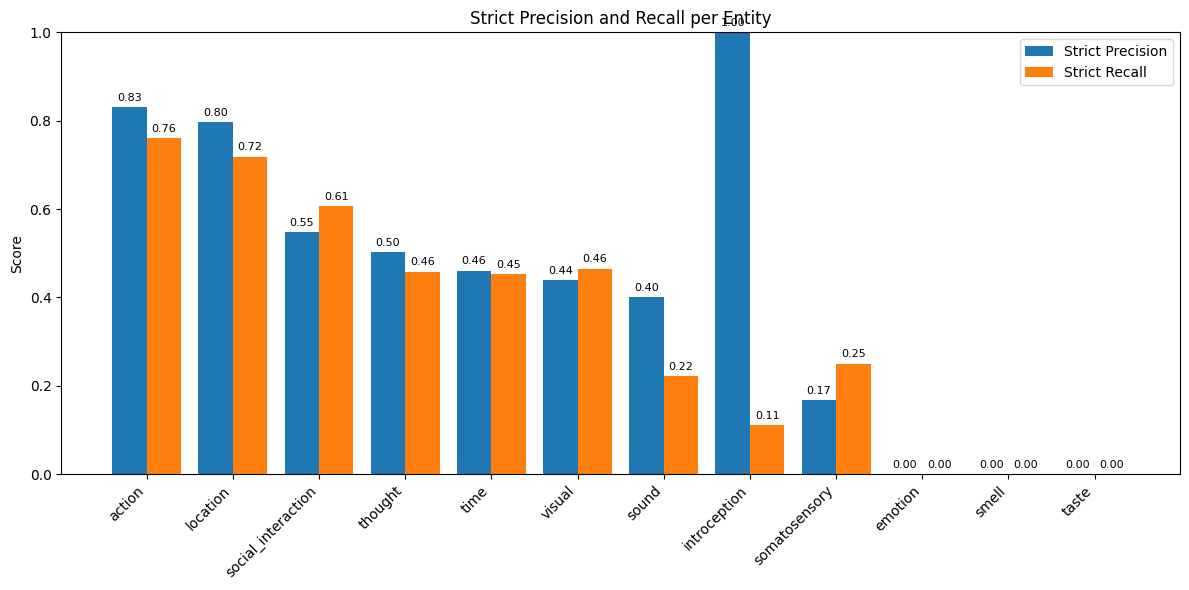

In [24]:
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - 0.2, df["Strict Precision"], width=0.4, label="Strict Precision")
bars2 = plt.bar(x + 0.2, df["Strict Recall"], width=0.4, label="Strict Recall")

# Label bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=8)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=8)

plt.xticks(x, df["Entity"], rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Strict Precision and Recall per Entity")
plt.legend()
plt.tight_layout()
plt.show()

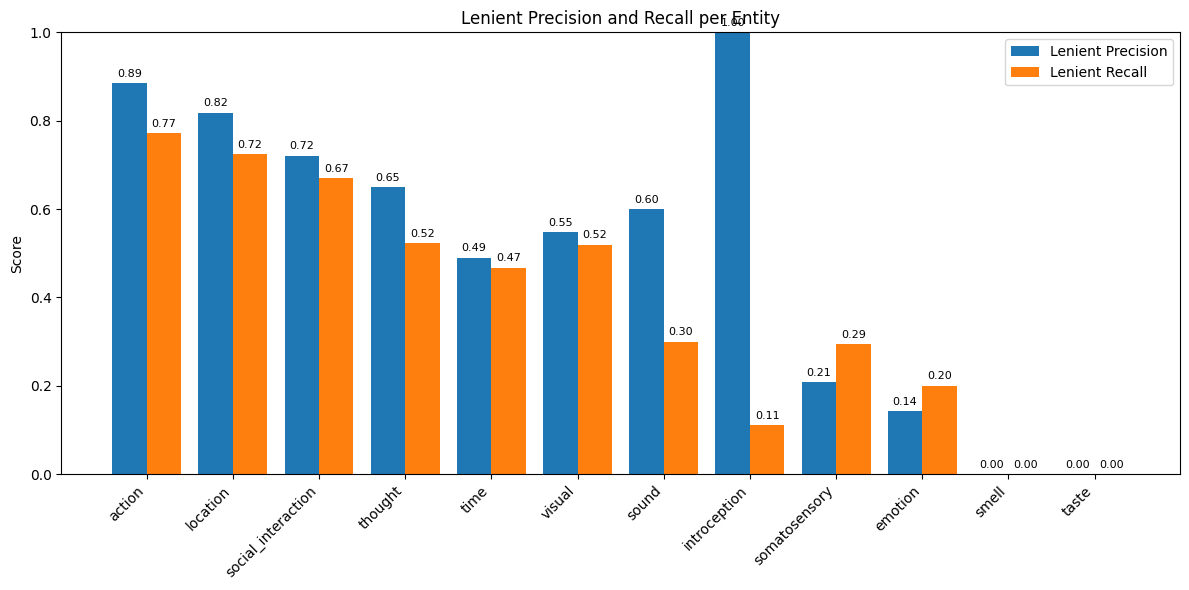

In [25]:
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - 0.2, df["Lenient Precision"], width=0.4, label="Lenient Precision")
bars2 = plt.bar(x + 0.2, df["Lenient Recall"], width=0.4, label="Lenient Recall")

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=8)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=8)

plt.xticks(x, df["Entity"], rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Lenient Precision and Recall per Entity")
plt.legend()
plt.tight_layout()
plt.show()


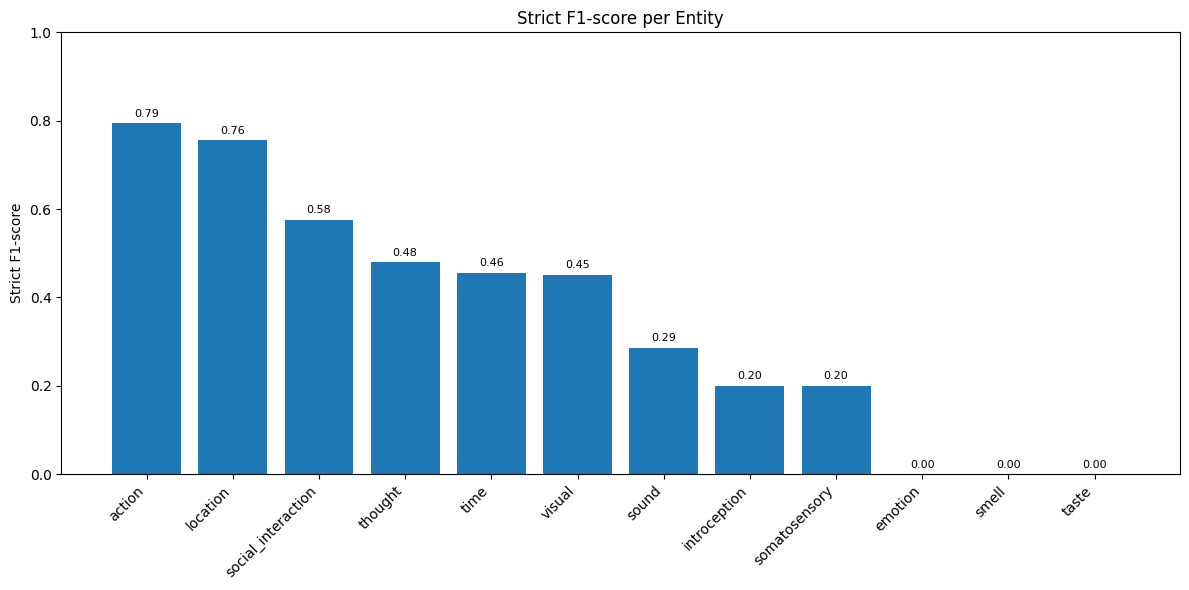

In [26]:
plt.figure(figsize=(12, 6))
bars = plt.bar(x, df["Strict F1-score"])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=8)

plt.xticks(x, df["Entity"], rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Strict F1-score")
plt.title("Strict F1-score per Entity")
plt.tight_layout()
plt.show()


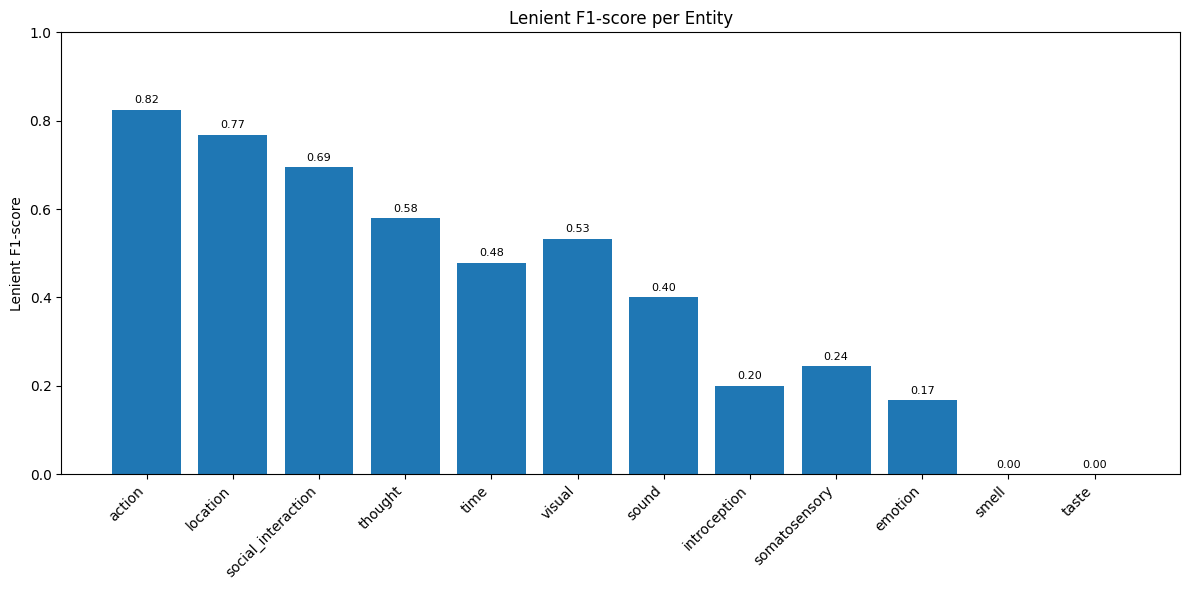

In [27]:
plt.figure(figsize=(12, 6))
bars = plt.bar(x, df["Lenient F1-score"])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", 
             ha='center', va='bottom', fontsize=8)

plt.xticks(x, df["Entity"], rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Lenient F1-score")
plt.title("Lenient F1-score per Entity")
plt.tight_layout()
plt.show()


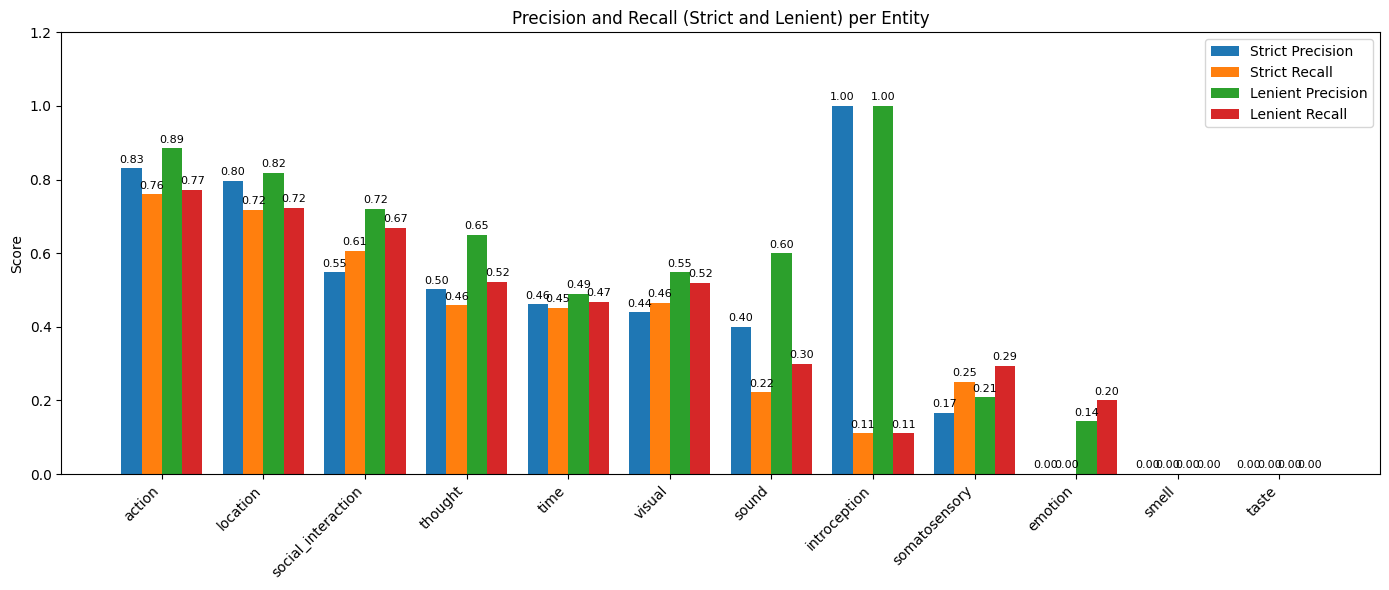

In [29]:
import matplotlib.pyplot as plt
import numpy as np

df = per_entity_df.copy()
x = np.arange(len(df))
width = 0.2

plt.figure(figsize=(14, 6))
bars1 = plt.bar(x - width*1.5, df["Strict Precision"], width=width, label="Strict Precision")
bars2 = plt.bar(x - width*0.5, df["Strict Recall"], width=width, label="Strict Recall")
bars3 = plt.bar(x + width*0.5, df["Lenient Precision"], width=width, label="Lenient Precision")
bars4 = plt.bar(x + width*1.5, df["Lenient Recall"], width=width, label="Lenient Recall")

# Add value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=8)

plt.xticks(x, df["Entity"], rotation=45, ha='right')
plt.ylim(0, 1.2)
plt.ylabel("Score")
plt.title("Precision and Recall (Strict and Lenient) per Entity")
plt.legend()
plt.tight_layout()
plt.show()


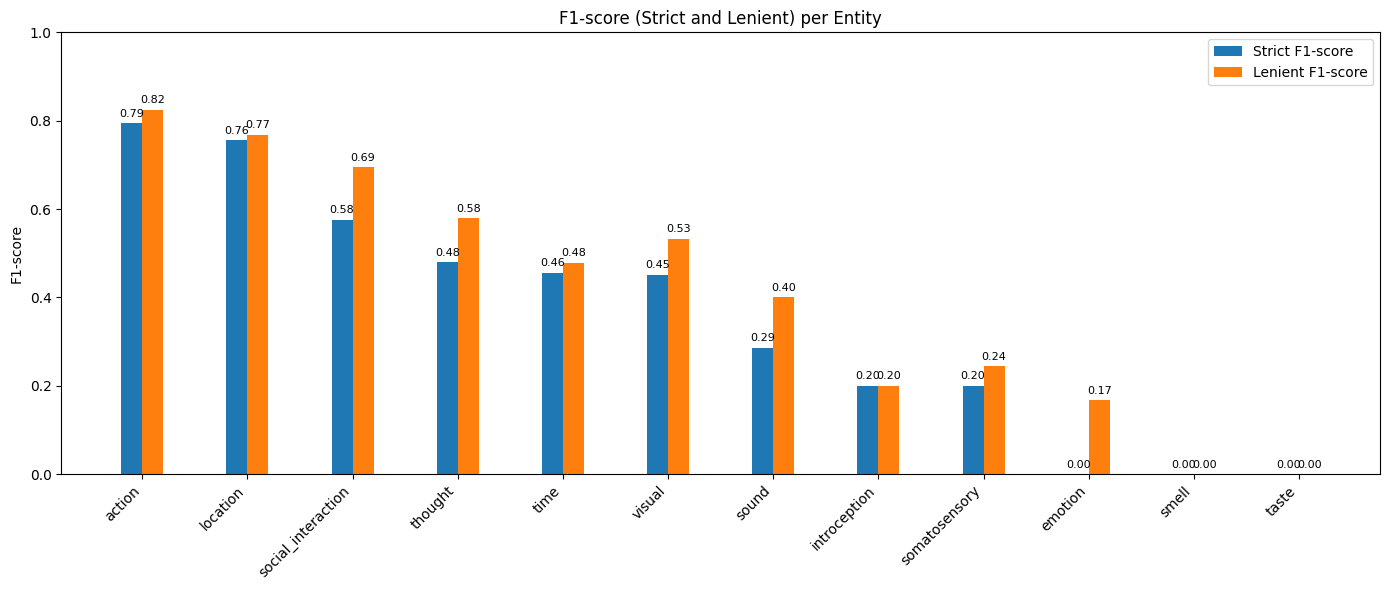

In [30]:
plt.figure(figsize=(14, 6))
bars1 = plt.bar(x - width/2, df["Strict F1-score"], width=width, label="Strict F1-score")
bars2 = plt.bar(x + width/2, df["Lenient F1-score"], width=width, label="Lenient F1-score")

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", 
                 ha='center', va='bottom', fontsize=8)

plt.xticks(x, df["Entity"], rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("F1-score (Strict and Lenient) per Entity")
plt.legend()
plt.tight_layout()
plt.show()
